In [93]:
import pandas as pd
import json
import numpy
import requests
import json
import csv
import matplotlib.pyplot as plt
import numpy as np

API Open data Paris - Traffic

In [83]:
## Nom du jeux de données 
dataset = "comptages-routiers-permanents"

# Période souhaité
jour1 = "2021-12-01"
jour2 = "2021-12-31"

# Libelle du capteur (laissé cette variable vide si vous souhaitez tous les capteurs il y'en a près de 3000.. cf le shape capteur.geojson fourni avec ce script)
# PI = Périphérique Intérieur / PE = Périphérique extérieur

libelle = "PE_Batignolles"

# Si un libelle de capteur est ajouté on rajoute une condition à la requête de l'API sinon on laisse vide
if len(libelle) >= 1 : 
    capteur = "&refine.libelle="+libelle
else :
    capteur = ""

# Nombre de ligne max (-1 pour tous)
nb_rows_max = '-1'

api_req = r"https://opendata.paris.fr/api/records/1.0/search/?dataset="+dataset+"&q=t_1h%3A%5B"+jour1+"T23%3A00%3A00Z+TO+"+jour2+"T22%3A59%3A59Z%5D&rows="+nb_rows_max+"&sort=t_1h&facet=libelle&facet=t_1h&facet=etat_trafic&facet=libelle_nd_amont&facet=libelle_nd_aval"+capteur

Téléchargement des données depuis l'API

In [84]:
r = requests.get(api_req, allow_redirects=True)
open('traffic.json', 'wb').write(r.content)


578200

Conversion du JSON en fichier CSV

In [85]:
## Le json est particulier et contient un dictionnaire il faut le normaliser

with open('traffic.json') as json_data:
    data = json.load(json_data)

df = pd.json_normalize(data["records"])

df.to_csv ('traffic.csv', index = None)

Explorer les données

In [86]:
#Importer CSV to dataframe

traffic = pd.read_csv("traffic.csv", sep=',')
traffic.head(2)

,datasetid,recordid,record_timestamp,fields.k,fields.q,fields.libelle,fields.iu_ac,fields.geo_point_2d,fields.geo_shape.coordinates,fields.geo_shape.type,...,fields.date_fin,fields.date_debut,fields.iu_nd_amont,fields.etat_trafic,fields.iu_nd_aval,fields.libelle_nd_amont,fields.etat_barre,fields.libelle_nd_aval,geometry.type,geometry.coordinates
0,comptages-routiers-permanents,07d76c5cbe4ce4542c42d86f9ce766f0b302337b,2021-12-31T22:25:00+00:00,11.80,4911.0,PE_Batignolles,5406,"[48.89875662632699, 2.3160291712781103]","[[2.3193519228, 48.899777396], [2.3162875738, ...",LineString,...,2019-06-01,2005-01-01,2849,Fluide,2087,PE_St_Ouen,Ouvert,SE_Clichy,Point,"[2.3160291712781103, 48.89875662632699]"
1,comptages-routiers-permanents,9d7fe716c5f096be7b93cef0f1cb393b9a34ef2d,2021-12-31T22:25:00+00:00,11.95,4947.0,PE_Batignolles,5406,"[48.89875662632699, 2.3160291712781103]","[[2.3193519228, 48.899777396], [2.3162875738, ...",LineString,...,2019-06-01,2005-01-01,2849,Fluide,2087,PE_St_Ouen,Ouvert,SE_Clichy,Point,"[2.3160291712781103, 48.89875662632699]"


Nettoyage des colonnes en trop dans le csv 

In [87]:
data = pd.read_csv('traffic.csv')

data.drop('datasetid', inplace=True, axis=1)
data.drop('recordid', inplace=True, axis=1)
data.drop('record_timestamp', inplace=True, axis=1)

data.to_csv('traffic.csv')

In [88]:
traffic = pd.read_csv("traffic.csv", sep=',')
traffic.head(2)

,Unnamed: 0,fields.k,fields.q,fields.libelle,fields.iu_ac,fields.geo_point_2d,fields.geo_shape.coordinates,fields.geo_shape.type,fields.t_1h,fields.date_fin,fields.date_debut,fields.iu_nd_amont,fields.etat_trafic,fields.iu_nd_aval,fields.libelle_nd_amont,fields.etat_barre,fields.libelle_nd_aval,geometry.type,geometry.coordinates
0,0,11.80,4911.0,PE_Batignolles,5406,"[48.89875662632699, 2.3160291712781103]","[[2.3193519228, 48.899777396], [2.3162875738, ...",LineString,2021-12-31T22:00:00+00:00,2019-06-01,2005-01-01,2849,Fluide,2087,PE_St_Ouen,Ouvert,SE_Clichy,Point,"[2.3160291712781103, 48.89875662632699]"
1,1,11.95,4947.0,PE_Batignolles,5406,"[48.89875662632699, 2.3160291712781103]","[[2.3193519228, 48.899777396], [2.3162875738, ...",LineString,2021-12-31T21:00:00+00:00,2019-06-01,2005-01-01,2849,Fluide,2087,PE_St_Ouen,Ouvert,SE_Clichy,Point,"[2.3160291712781103, 48.89875662632699]"


In [89]:
## Renomme les champs
traffic.rename(columns={'fields.k': 'k','fields.q': 'q','fields.libelle': 'libelle', 'fields.t_1h' : 'time', 'fields.etat_trafic': 'etat_traffic'}, inplace=True)

## Reorganiser le tableau
traffic = traffic[["libelle", "time", "k", "q", "etat_traffic", "geometry.coordinates"]]

## Voir les types
traffic.dtypes

libelle                  object
time                     object
k                       float64
q                       float64
etat_traffic             object
geometry.coordinates     object
dtype: object

On ordonne le dataframe par date et heure

In [90]:
traffic.sort_values(by=['time'], ascending=True)
traffic.head(10)

,libelle,time,k,q,etat_traffic,geometry.coordinates
0,PE_Batignolles,2021-12-31T22:00:00+00:00,11.80,4911.0,Fluide,"[2.3160291712781103, 48.89875662632699]"
1,PE_Batignolles,2021-12-31T21:00:00+00:00,11.95,4947.0,Fluide,"[2.3160291712781103, 48.89875662632699]"
2,PE_Batignolles,2021-12-31T20:00:00+00:00,14.60,5907.0,Fluide,"[2.3160291712781103, 48.89875662632699]"
3,PE_Batignolles,2021-12-31T19:00:00+00:00,16.75,6491.0,Pré-saturé,"[2.3160291712781103, 48.89875662632699]"
4,PE_Batignolles,2021-12-31T18:00:00+00:00,15.50,6147.0,Pré-saturé,"[2.3160291712781103, 48.89875662632699]"
5,PE_Batignolles,2021-12-31T17:00:00+00:00,16.25,6279.0,Pré-saturé,"[2.3160291712781103, 48.89875662632699]"
6,PE_Batignolles,2021-12-31T16:00:00+00:00,16.30,6500.0,Pré-saturé,"[2.3160291712781103, 48.89875662632699]"
7,PE_Batignolles,2021-12-31T15:00:00+00:00,16.55,6591.0,Pré-saturé,"[2.3160291712781103, 48.89875662632699]"
8,PE_Batignolles,2021-12-31T14:00:00+00:00,15.10,6229.0,Pré-saturé,"[2.3160291712781103, 48.89875662632699]"
9,PE_Batignolles,2021-12-31T13:00:00+00:00,15.20,6229.0,Pré-saturé,"[2.3160291712781103, 48.89875662632699]"


Courbe de l'évolution du traffic

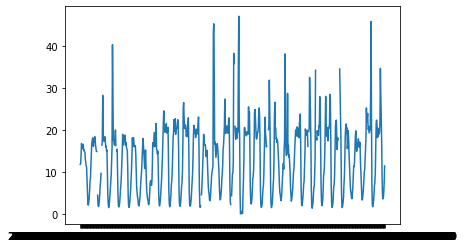

<Figure size 432x288 with 0 Axes>

In [96]:
plt.plot(traffic["time"], traffic["k"]) 
plt.show() 